<a href="https://colab.research.google.com/github/chocopi314/SarcasmTweetDetect/blob/main/CS97_proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sarcasm Detection

In [1]:
import random
random.seed(42)

In [2]:
# Helper functions

from sklearn import metrics
#feel free to use this helper function to print accuracy, precision, recall, F1
def print_4_metrics(target_test, predicted):
  print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(target_test,predicted)))
  print("%-12s %f" % ('Precision:', metrics.precision_score(target_test, predicted,labels=None, pos_label=1, average='binary', sample_weight=None)))
  print("%-12s %f" % ('Recall:', metrics.recall_score(target_test, predicted,labels=None, pos_label=1, average='binary', sample_weight=None)))
  print("%-12s %f" % ('F1 Score:', metrics.f1_score(target_test, predicted,labels=None, pos_label=1, average='binary', sample_weight=None)))

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

# Helper function that allows you to draw nicely formatted confusion matrices
def draw_confusion_matrix(y, yhat, classes):
    '''
        Draws a confusion matrix for the given target and predictions
        Adapted from scikit-learn and discussion example.
    '''
    plt.cla()
    plt.clf()
    matrix = confusion_matrix(y, yhat)
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    num_classes = len(classes)
    plt.xticks(np.arange(num_classes), classes, rotation=90)
    plt.yticks(np.arange(num_classes), classes)

    fmt = 'd'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if matrix[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Load the data

In [3]:
import pandas as pd
url='https://drive.google.com/file/d/1xZ_dhMRAMx-c9OyehwB_DX6qmX7tHso3/view?usp=sharing'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
df = pd.read_csv(url,  sep='\t')
df.head()

,tweets,label
0,I love working midnights tweet,1
1,I hate when I buy a bag of air and there's chi...,1
2,my grandad always sounds so ill when i speak t...,0
3,"I realize I'm annoying to everyone, so I won't...",0
4,I love when I find these dudes on vine!! #Foll...,1


# Pre-processing Data

In [4]:
data_unlabeled = df['tweets']
# data_unlabeled.head()
data_labels = df['label']
# data_labels.head()
len(data_unlabeled)

data_unlabeled.info()

<class 'pandas.core.series.Series'>
RangeIndex: 1994 entries, 0 to 1993
Series name: tweets
Non-Null Count  Dtype 
--------------  ----- 
1994 non-null   object
dtypes: object(1)
memory usage: 15.7+ KB


<Axes: >

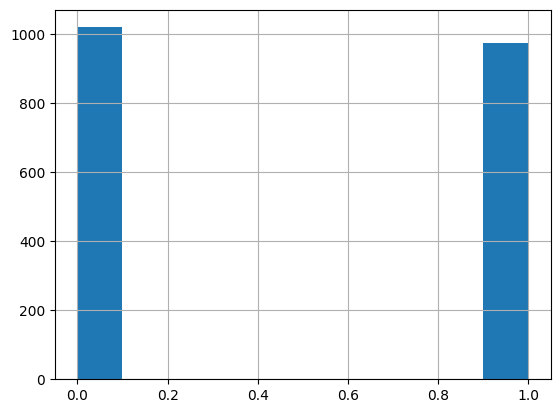

In [5]:
data_labels.hist()

In [6]:
pd.set_option('max_colwidth', None)

In [7]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [8]:
data_clean = data_unlabeled.replace('[^ -~]+', '', regex=True) # clean data; get rid of weird characters

In [9]:
data_clean

0                                                                                                  I love working midnights tweet 
1                                                                    I hate when I buy a bag of air and there's chips in it  #not 
2                                                                my grandad always sounds so ill when i speak to him on the phone 
3                           I realize I'm annoying to everyone, so I won't keep spamming you, twitter, I'll speak when spoken too 
4                                                         I love when I find these dudes on vine!! #FollowMe #giveaway #Xbox360   
                                                                   ...                                                            
1989                                   his phone keeps going off, more like his wife keeps walking in when he texts me #yeahright 
1990                                                            ii wish you can cal

In [10]:
data_clean = data_clean.str.replace('[^\w\s]','', regex=True) # remove punctuation
data_clean = data_clean.replace('_', '', regex=True) # remove underscores
data_clean = data_clean.replace('\d+', '', regex=True) # remove numbers

In [11]:
import spacy
spacy_lol = spacy.load('en_core_web_sm', disable = ['parser','ner'])

def lemmatize(tweet):
    doc = spacy_lol(tweet)
    return " ".join([token.lemma_ for token in doc])

data_clean = data_clean.apply(lemmatize)

In [12]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
data_clean = data_clean.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)])) # remove stop words
data_clean = data_clean.apply(lambda x: " ".join(x.lower() for x in x.split())) # to lower case TODO fixxxx

In [13]:
data_clean.head()

0                                             i love work midnight tweet
1                                              i hate i buy bag air chip
2                                 grandad always sound ill i speak phone
3    i realize i annoying everyone i keep spamme twitter ill speak speak
4                         i love i find dude vine followme giveaway xbox
Name: tweets, dtype: object

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
# ngram currently unigram, can play around later
n=1
ngram_range=(n, n)
vectorizer = TfidfVectorizer(ngram_range=ngram_range)
X = vectorizer.fit_transform(data_clean)
# print(vectorizer.get_feature_names_out()[-300:-280])
# X.shape

tfidf_matrix = pd.DataFrame(X.toarray(), columns = vectorizer.get_feature_names_out())
# X[0:10][0:10]
# plt.spy(tfidf_matrix, markersize = 0.3)

# Train Test Split

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, data_labels, train_size = 0.8, test_size=0.2, random_state=4)

# SVM

No Regularization

Accuracy:    0.894737
Precision:   0.936170
Recall:      0.854369
F1 Score:    0.893401
SVM Model Performance Results:

AUC of ROC:  0.941118768549726


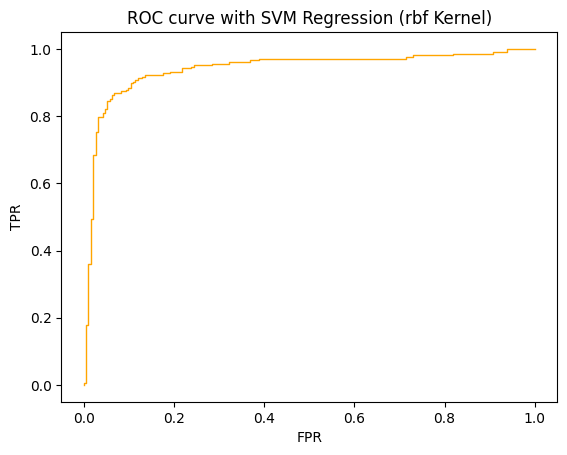

In [16]:
# SVM Model with no Regularization (C -> inf, lambda -> 0)
import numpy as np
from sklearn.svm import SVC
from matplotlib import pyplot

svm = SVC(probability = True, C=1e10)

svm.fit(X_train, y_train)

svm_predicted = svm.predict(X_test)
svm_score = svm.predict_proba(X_test)[:,1]

print_4_metrics(y_test, svm_predicted)

# Plot ROC curve and report area under ROC
# use metrics.roc_curve(your y_test, predicted probabilities for y_test)
# feel free to use the same code as 3.1.1.
'''your code goes below here'''
fpr_svm_reg, tpr_svm_reg, thresholds = metrics.roc_curve(y_test,svm_score)
print("SVM Model Performance Results:\n")
pyplot.figure(1)
pyplot.plot(fpr_svm_reg, tpr_svm_reg, color='orange', lw=1)
pyplot.title("ROC curve with SVM Regression (rbf Kernel)")
pyplot.xlabel('FPR')
pyplot.ylabel('TPR')
# report auc
# use metrics.auc(fpr, tpr)
aucroc = metrics.auc(fpr_svm_reg, tpr_svm_reg)
print('AUC of ROC: ', aucroc)

Confusion Matrix: 



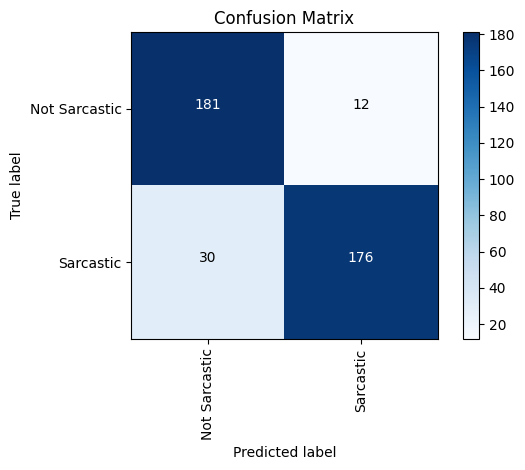

In [17]:
print("Confusion Matrix: \n")
draw_confusion_matrix(y_test, svm_predicted, ['Not Sarcastic', 'Sarcastic'])

Cross Validation

In [18]:
from sklearn import model_selection

lambda_list = np.linspace(start = 1, stop = 2, num = 20)
accuracy_list = []
for lambd in lambda_list:
    kfold = model_selection.KFold(n_splits=10, random_state=42, shuffle=True)
    # Train the model
    svc_model_kfold_train = SVC(probability = True, C = 1/lambd)
    svc_results_kfold_train = model_selection.cross_val_score(svc_model_kfold_train, X_train, y_train, cv=kfold)
    # Calculate accuracy
    accuracy = svc_results_kfold_train.mean()
    # Append lambda and accuracy to the lists
    accuracy_list.append(accuracy)

    print("For lambda=",lambd, ", accuracy across folds is: %.2f%%" % (svc_results_kfold_train.mean()*100.0))

For lambda= 1.0 , accuracy across folds is: 91.73%
For lambda= 1.0526315789473684 , accuracy across folds is: 91.79%
For lambda= 1.1052631578947367 , accuracy across folds is: 91.85%
For lambda= 1.1578947368421053 , accuracy across folds is: 91.85%
For lambda= 1.2105263157894737 , accuracy across folds is: 91.92%
For lambda= 1.263157894736842 , accuracy across folds is: 91.92%
For lambda= 1.3157894736842106 , accuracy across folds is: 91.79%
For lambda= 1.368421052631579 , accuracy across folds is: 91.73%
For lambda= 1.4210526315789473 , accuracy across folds is: 91.66%
For lambda= 1.4736842105263157 , accuracy across folds is: 91.66%
For lambda= 1.526315789473684 , accuracy across folds is: 91.66%
For lambda= 1.5789473684210527 , accuracy across folds is: 91.66%
For lambda= 1.631578947368421 , accuracy across folds is: 91.66%
For lambda= 1.6842105263157894 , accuracy across folds is: 91.60%
For lambda= 1.736842105263158 , accuracy across folds is: 91.60%
For lambda= 1.7894736842105263

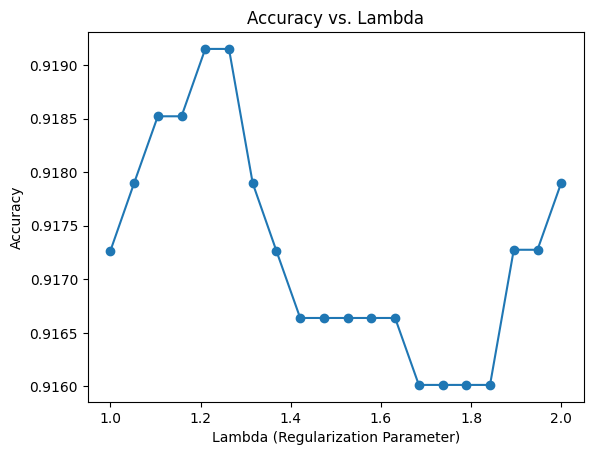

In [19]:
# Plot the scatter plot
plt.figure()
plt.scatter(lambda_list, accuracy_list)
plt.plot(lambda_list, accuracy_list)
plt.xlabel('Lambda (Regularization Parameter)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Lambda')
plt.show()

In [20]:
# comparison of label vs svm model's calculated value of P(Y=1|X)
print("label\tP(Y=1)\tCorrect?")
for i in range(0,10):
    print(y_test.iloc[i], " ", svm_score[i], " ", str((y_test.iloc[i] == 1 and svm_score[i] >= 0.5) or (y_test.iloc[i] == 0 and svm_score[i] < 0.5)))

label	P(Y=1)	Correct?
1   0.9775560401053158   True
1   0.14066423487584978   False
1   0.9765971468704417   True
0   0.29007930283527095   True
1   0.9392365781916364   True
1   0.9932114444065023   True
1   0.9888465032867881   True
1   0.9957578212436565   True
1   0.3298580304591642   False
1   0.28465208371508605   False


'Optimal' lambda

Accuracy:    0.897243
Precision:   0.936508
Recall:      0.859223
F1 Score:    0.896203
SVM Model Performance Results:

AUC of ROC:  0.9431560943709442


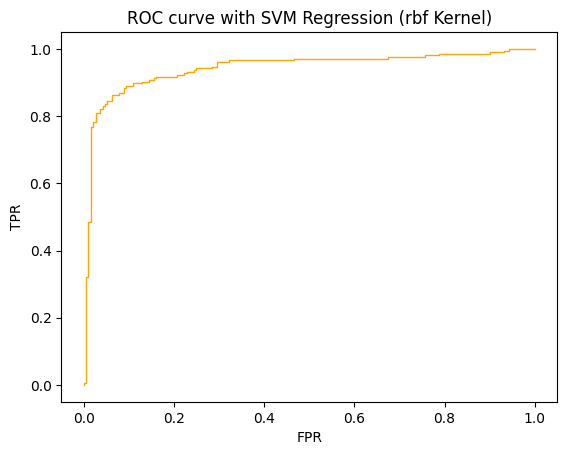

In [21]:
# SVM Model with Regularization from CV (lambda=1.526315789473684)


lambd=1.263157894736842
svm = SVC(probability = True, C=1/lambd)

svm.fit(X_train, y_train)

svm_predicted = svm.predict(X_test)
svm_score = svm.predict_proba(X_test)[:,1]

print_4_metrics(y_test, svm_predicted)

# Plot ROC curve and report area under ROC
# use metrics.roc_curve(your y_test, predicted probabilities for y_test)
# feel free to use the same code as 3.1.1.
'''your code goes below here'''
fpr_svm_reg, tpr_svm_reg, thresholds = metrics.roc_curve(y_test,svm_score)
print("SVM Model Performance Results:\n")
pyplot.figure(1)
pyplot.plot(fpr_svm_reg, tpr_svm_reg, color='orange', lw=1)
pyplot.title("ROC curve with SVM Regression (rbf Kernel)")
pyplot.xlabel('FPR')
pyplot.ylabel('TPR')
# report auc
# use metrics.auc(fpr, tpr)
aucroc = metrics.auc(fpr_svm_reg, tpr_svm_reg)
print('AUC of ROC: ', aucroc)

+0.2506% accuracy from 'no' regularization.

## Top 20 Words



In [22]:
# top 20 important words
importance = np.argsort(np.asarray(X.sum(axis=0)).ravel())[::-1] # returns indices of top 20 words
tfidf_feature_names = np.array(vectorizer.get_feature_names_out())
# print(tfidf_feature_names[importance[:20]])


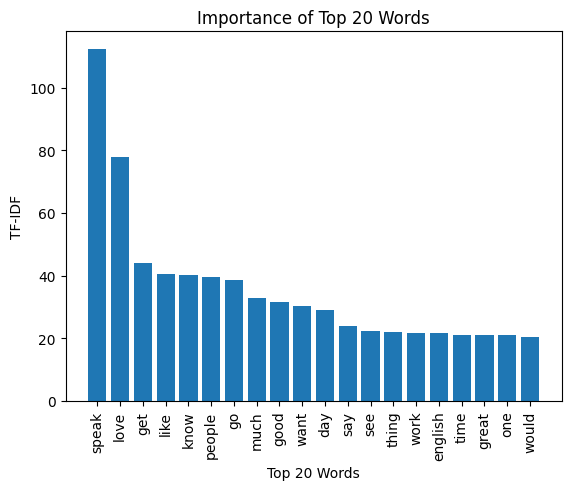

In [23]:
top_20_words = list(tfidf_feature_names[importance[:20]])
tfidf_top20_values = np.array(X[:,importance[:20]].sum(axis=0)).flatten()
# print(tfidf_top20_values)
plt.bar(range(len(top_20_words)), tfidf_top20_values)
plt.xticks(range(len(top_20_words)), top_20_words, rotation='vertical')
plt.title('Importance of Top 20 Words')
plt.ylabel('TF-IDF')
plt.xlabel('Top 20 Words')
plt.show()

# Logistic Regression

No Penalty

Accuracy:    0.872180
Precision:   0.897436
Recall:      0.849515
F1 Score:    0.872818


Confusion Matrix: 



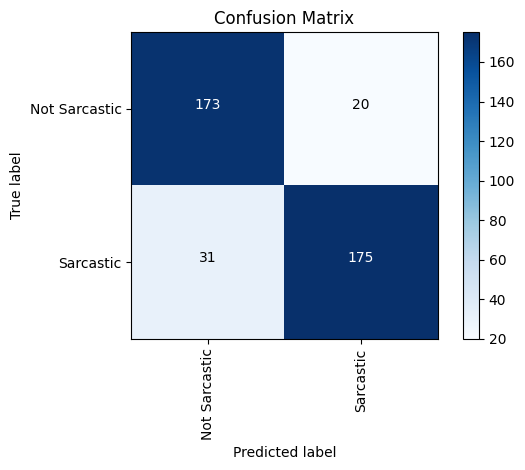

In [24]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(penalty=None)
log_reg.fit(X_train, y_train)
log_predicted = log_reg.predict(X_test)
log_score = log_reg.predict_proba(X_test)[:,1]

print_4_metrics(y_test, log_predicted)

print("\n\nConfusion Matrix: \n")
draw_confusion_matrix(y_test, log_predicted, ['Not Sarcastic', 'Sarcastic'])

Cross Validation

For lambda= 2.0 , accuracy across folds is: 91.73%
For lambda= 2.0526315789473686 , accuracy across folds is: 91.73%
For lambda= 2.1052631578947367 , accuracy across folds is: 91.73%
For lambda= 2.1578947368421053 , accuracy across folds is: 91.73%
For lambda= 2.2105263157894735 , accuracy across folds is: 91.73%
For lambda= 2.263157894736842 , accuracy across folds is: 91.73%
For lambda= 2.3157894736842106 , accuracy across folds is: 91.73%
For lambda= 2.3684210526315788 , accuracy across folds is: 91.79%
For lambda= 2.4210526315789473 , accuracy across folds is: 91.79%
For lambda= 2.473684210526316 , accuracy across folds is: 91.73%
For lambda= 2.526315789473684 , accuracy across folds is: 91.66%
For lambda= 2.5789473684210527 , accuracy across folds is: 91.66%
For lambda= 2.6315789473684212 , accuracy across folds is: 91.66%
For lambda= 2.6842105263157894 , accuracy across folds is: 91.66%
For lambda= 2.736842105263158 , accuracy across folds is: 91.66%
For lambda= 2.789473684210526

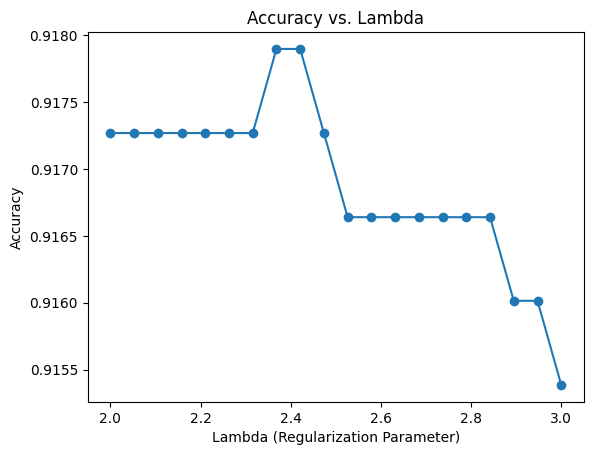

In [25]:
lambda_list = np.linspace(start = 2, stop = 3, num = 20)
accuracy_list = []
for lambd in lambda_list:
    kfold = model_selection.KFold(n_splits=10, random_state=42, shuffle=True)
    # Train the model
    log_model_kfold_train = LogisticRegression(C = 1/lambd)
    log_results_kfold_train = model_selection.cross_val_score(log_model_kfold_train, X_train, y_train, cv=kfold)
    # Calculate accuracy
    accuracy = log_results_kfold_train.mean()
    # Append lambda and accuracy to the lists
    accuracy_list.append(accuracy)
    print("For lambda=",lambd, ", accuracy across folds is: %.2f%%" % (log_results_kfold_train.mean()*100.0))

# Plot the scatter plot
plt.figure()
plt.scatter(lambda_list, accuracy_list)
plt.plot(lambda_list, accuracy_list)
plt.xlabel('Lambda (Regularization Parameter)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Lambda')
plt.show()

With Regularization (lambda = 2.4210526315789473)



Accuracy:    0.889724
Precision:   0.930851
Recall:      0.849515
F1 Score:    0.888325


Confusion Matrix: 



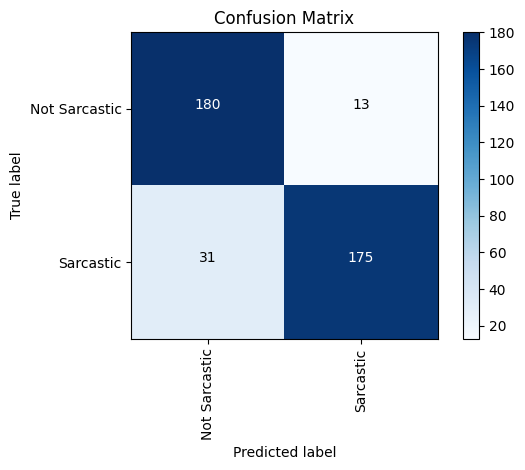

In [26]:
lambd = 2.4210526315789473

log_reg = LogisticRegression(penalty='l2', C=1/lambd)
log_reg.fit(X_train, y_train)
log_predicted = log_reg.predict(X_test)
log_score = log_reg.predict_proba(X_test)[:,1]

print_4_metrics(y_test, log_predicted)

print("\n\nConfusion Matrix: \n")
draw_confusion_matrix(y_test, log_predicted, ['Not Sarcastic', 'Sarcastic'])

+1.7544% accuracy after regularization

In [27]:
print("label\tP(Y=1)\tCorrect?")
for i in range(0,10):
    print(y_test.iloc[i], " ", log_score[i], " ", str((y_test.iloc[i] == 1 and log_score[i] >= 0.5) or (y_test.iloc[i] == 0 and log_score[i] < 0.5)))

label	P(Y=1)	Correct?
1   0.733475507684517   True
1   0.3740003549174688   False
1   0.7223149523925655   True
0   0.4347468420055582   True
1   0.6284166683106889   True
1   0.7740590238988894   True
1   0.7801431883799119   True
1   0.8303543588677306   True
1   0.42275086024576547   False
1   0.395079104987375   False


In [28]:
accuracy_list

[0.9172680817610063,
 0.9172680817610063,
 0.9172680817610063,
 0.9172680817610063,
 0.9172680817610063,
 0.9172680817610063,
 0.9172680817610063,
 0.9178970125786163,
 0.9178970125786163,
 0.9172680817610063,
 0.9166391509433962,
 0.9166391509433962,
 0.9166391509433962,
 0.9166391509433962,
 0.9166391509433962,
 0.9166391509433962,
 0.9166391509433962,
 0.9160141509433963,
 0.9160141509433963,
 0.915385220125786]

# RNN

In [29]:
data_clean

0                                                i love work midnight tweet
1                                                 i hate i buy bag air chip
2                                    grandad always sound ill i speak phone
3       i realize i annoying everyone i keep spamme twitter ill speak speak
4                            i love i find dude vine followme giveaway xbox
                                       ...                                 
1989                     phone keep go like wife keep walk text i yeahright
1990                              ii wish call opp amp like may i speak amp
1991                ever song speak much force sit car listen i love happen
1992                            anyone torrent new u album i like pay music
1993                          good way start day ihaveafever animalhospital
Name: tweets, Length: 1994, dtype: object

In [30]:
pip install pad-sequences

  Preparing metadata (setup.py) ... done
  Created wheel for pad-sequences: filename=pad_sequences-0.6.1-py3-none-any.whl size=10199 sha256=f9ef99c325f4acef34a15bb4d19626211f8485b64a16b19c56915d6bcdf347c9
  Stored in directory: /root/.cache/pip/wheels/48/9d/22/0a6305b87a9cc46ccc032060a041c3b59f39ac462f7358997e
Successfully built pad-sequences


In [39]:
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

max_features = 2000

tokenizer = Tokenizer(max_features, split = ' ')
tokenizer.fit_on_texts(data_clean)
X_tokenized = tokenizer.texts_to_sequences(data_clean)
X_padded = pad_sequences(X_tokenized)

# X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = train_test_split(X_padded, data_labels, test_size=0.2, random_state=4)

X_train_rnn, X_rem, y_train_rnn, y_rem = train_test_split(X_padded,data_labels, train_size=0.8)

# Now since we want the valid and test size to be equal (10% each of overall data).
# we have to define valid_size=0.5 (that is 50% of remaining data)
test_size = 0.5
X_valid, X_test_rnn, y_valid, y_test_rnn = train_test_split(X_rem,y_rem, test_size=0.5)

In [40]:
print(X_train_rnn.shape)
print(X_test_rnn.shape)
print(X_valid.shape)

(1595, 27)
(200, 27)
(199, 27)


In [43]:
from keras.models import Sequential
from keras.layers import Embedding, Dense, BatchNormalization, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras import layers, regularizers

model = Sequential()

# hyperparams

embed_vec_size = 120 # hyperparam that controls size of embedding vector
num_layers = 200 # also hyperparam
batch_size = 32
learning_rate=0.0001
dropout_rate = 0.5
reg_strength = 0.005
patience = 10

# optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam']
# batch_size = [16,32,64,128,256]

model.add(Embedding(input_dim=max_features, output_dim=embed_vec_size))
model.add(layers.LSTM(num_layers, dropout=dropout_rate, return_sequences=True))
model.add(BatchNormalization())
model.add(layers.LSTM(num_layers, dropout=dropout_rate))  # Additional LSTM layer
model.add(BatchNormalization())
model.add(Dropout(dropout_rate))
model.add(Dense(units=50, activation='relu', kernel_regularizer=regularizers.l2(reg_strength)))
# model.add(Dropout(dropout_rate))
model.add(Dense(units=1, activation='sigmoid'))

early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
hist = model.fit(X_train_rnn, y_train_rnn, epochs=100, batch_size=batch_size, validation_data=(X_valid, y_valid), callbacks=[early_stopping]) # , callbacks=[early_stopping]
score = model.evaluate(X_test_rnn, y_test_rnn) # 2-element vector containing loss, and accuracy

print('Test loss: ', score[0])
print('Test accuracy: ', score[1])




Epoch 1/100
50/50 [==============================] - 18s 260ms/step - loss: 1.1485 - accuracy: 0.6169 - val_loss: 1.0829 - val_accuracy: 0.5276
Epoch 2/100
50/50 [==============================] - 12s 238ms/step - loss: 0.9565 - accuracy: 0.7429 - val_loss: 1.0738 - val_accuracy: 0.5276
Epoch 3/100
50/50 [==============================] - 12s 242ms/step - loss: 0.8659 - accuracy: 0.7925 - val_loss: 1.0639 - val_accuracy: 0.5276
Epoch 4/100
50/50 [==============================] - 12s 241ms/step - loss: 0.7721 - accuracy: 0.8357 - val_loss: 1.0487 - val_accuracy: 0.5276
Epoch 5/100
50/50 [==============================] - 12s 240ms/step - loss: 0.7240 - accuracy: 0.8721 - val_loss: 1.0271 - val_accuracy: 0.5276
Epoch 6/100
50/50 [==============================] - 11s 228ms/step - loss: 0.6989 - accuracy: 0.8702 - val_loss: 0.9790 - val_accuracy: 0.5528
Epoch 7/100
50/50 [==============================] - 11s 217ms/step - loss: 0.6716 - accuracy: 0.8890 - val_loss: 0.9028 - val_accuracy:

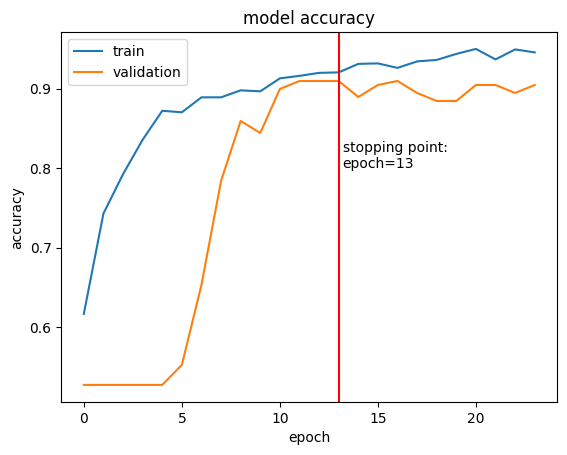

In [44]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
stop_epoch = early_stopping.stopped_epoch-patience
plt.axvline(stop_epoch, color='r')
label = 'stopping point: \nepoch=' + str(stop_epoch)
plt.text(stop_epoch+0.2, .8, label, rotation=0)
plt.show()

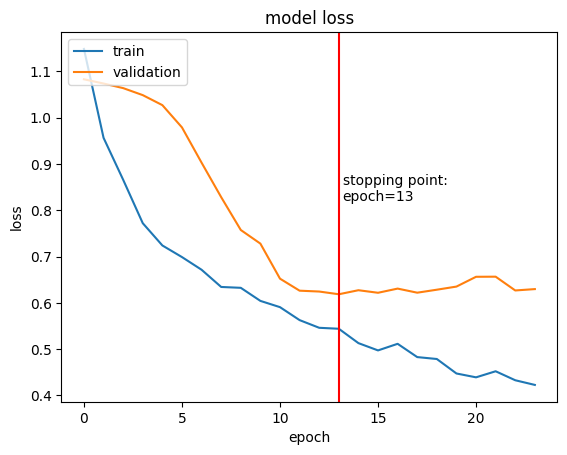

In [45]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axvline(stop_epoch, color='r')
plt.text(stop_epoch+0.2,.82, label,rotation=0)
plt.show()

hyperparam tuning

In [36]:
pip install scikeras

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Dense, BatchNormalization, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras import layers, regularizers
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier

#https://www.geeksforgeeks.org/hyperparameter-tuning-using-gridsearchcv-and-kerasclassifier/#

def create_model(batch_size=32, num_layers=200, dropout_rate=0.5, embed_vec_size=120, learning_rate=0.0001, optimizer='adam'):
    model = Sequential()
    model.add(Embedding(input_dim=max_features, output_dim=embed_vec_size))
    model.add(layers.LSTM(num_layers, dropout=dropout_rate, return_sequences=True))
    model.add(BatchNormalization())
    model.add(layers.LSTM(num_layers, dropout=dropout_rate))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=50, activation='relu', kernel_regularizer=regularizers.l2(reg_strength)))
    model.add(Dense(units=1, activation='sigmoid'))
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

patience = 10

param_grid = {
    # 'batch_size': [32, 64, 128],
    'num_layers': [150, 200, 250],
    # 'dropout_rate': [0.3, 0.5, 0.7],
    # 'embed_vec_size': [120, 160, 200],
    'learning_rate': [0.001, 0.0001, 0.00001],
    'optimizer':['adam', 'sgd', 'rmsprop']
}

model = KerasClassifier(model=create_model, epochs=20, loss="binary_crossentropy", dropout_rate=0.5, embed_vec_size=120, learning_rate=0.0001, num_layers=200)


grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=2)
grid_result = grid.fit(X_train_rnn, y_train_rnn, callbacks=[early_stopping], validation_data=(X_valid, y_valid))
best_params=grid_result.best_params_
accuracy=grid_result.best_score_

print("best params: ", best_params)
print("average validation accuracy across all folds and hyperparameter combinations: ", accuracy)




Fitting 3 folds for each of 27 candidates, totalling 81 fits
Epoch 1/20
34/34 [==============================] - 13s 213ms/step - loss: 0.9801 - accuracy: 0.6999 - val_loss: 1.0206 - val_accuracy: 0.8241
Epoch 2/20
34/34 [==============================] - 5s 140ms/step - loss: 0.6175 - accuracy: 0.8937 - val_loss: 0.9739 - val_accuracy: 0.6884
Epoch 3/20
34/34 [==============================] - 6s 165ms/step - loss: 0.5334 - accuracy: 0.9135 - val_loss: 0.9327 - val_accuracy: 0.8844
Epoch 4/20
29/34 [========================>.....] - ETA: 0s - loss: 0.4690 - accuracy: 0.9235

In [ ]:
print("Grid Search CV best accuracy: ", grid_result.best_estimator_.score(X_train_rnn, y_train_rnn))

optimized hyperparameters

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Dense, BatchNormalization, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras import layers, regularizers
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier

embed_vec_size = 120 # hyperparam that controls size of embedding vector
num_layers = 200 # also hyperparam
batch_size = 32
learning_rate=1e-5
dropout_rate = 0.5
reg_strength = 0.005
patience = 100

model = Sequential()

model.add(Embedding(input_dim=max_features, output_dim=embed_vec_size))
model.add(layers.LSTM(num_layers, dropout=dropout_rate, return_sequences=True))
model.add(BatchNormalization())
model.add(layers.LSTM(num_layers, dropout=dropout_rate))  # Additional LSTM layer
model.add(BatchNormalization())
model.add(Dropout(dropout_rate))
model.add(Dense(units=50, activation='relu', kernel_regularizer=regularizers.l2(reg_strength)))
# model.add(Dropout(dropout_rate))
model.add(Dense(units=1, activation='sigmoid'))

early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
hist = model.fit(X_train_rnn, y_train, epochs=100, batch_size=batch_size, validation_data=(X_test_rnn, y_test), callbacks=[early_stopping]) # , callbacks=[early_stopping]
score = model.evaluate(X_test_rnn, y_test) # 2-element vector containing loss, and accuracy

print('Test loss: ', score[0])
print('Test accuracy: ', score[1])
